Project work for course Introduction to Audio processing.
This project consist of binary sound classification of cars and trams. 

In [2]:
import os
import librosa as lb
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:
def get_files_from_folder(path):
    files = os.listdir(path)
    return files

def normalize_audio(audio):
    max_amp = np.max(np.abs(audio))
    normalized_audio = audio / max_amp
    return normalized_audio

def resample(audio, sr, new_sr=44100):
    # If the sampling rate is already the target sampling rate
    if (sr == new_sr):
      return audio, sr

    audio_resampled = lb.resample(audio, orig_sr=sr, target_sr=new_sr)
    return audio_resampled, new_sr

def pad_or_trunc(audio, sr, target_duration=5):
    # Trim or pad to the target duration
    target_length = int(sr * target_duration)
    
    if len(audio) < target_length:
        # Pad with silence
        audio = np.pad(audio, (0, target_length - len(audio)))
    elif len(audio) > target_length:
        # Trim to the target duration
        audio = audio[:target_length]

    return audio, sr

Feature extraction for the data.

The Cardata and Tramdata folders include recorded audio files from cars and trams. Any suitable data could be used for this project. 

In [4]:
# Lets store the filenames 
carfiles = get_files_from_folder("./Cardata/")
tramfiles = get_files_from_folder("./Tramdata/")

# Load and store the audio data
sr = 44100
cardata = []
tramdata = []

for i in range(0, len(carfiles)):
    path = './Cardata/' + carfiles[i]
    audio, fs = lb.load(path, sr=None)
    audio, fs = resample(audio, fs, sr) # Resample audio if needed
    audio, fs = pad_or_trunc(audio, fs, 5) # Make signals the same length
    audio = normalize_audio(audio) 
    cardata.append(audio)

    # Same for trams (there are same number of samples than cars)
    path = './Tramdata/' + tramfiles[i]
    audio, fs = lb.load(path, sr=None)
    audio, fs = resample(audio, fs, sr) # Resample audio if needed
    audio, fs = pad_or_trunc(audio, fs, 5) # Make signals the same length
    audio = normalize_audio(audio) 
    tramdata.append(audio)

cardata = np.array(cardata)
tramdata= np.array(tramdata)

In [5]:
def calculate_energy_and_rms(signal):
    energy = np.sum(signal**2)
    rms = np.sqrt(np.mean(signal ** 2))
    return energy, rms

In [6]:
# Calculate sound energies and RMS
car_energies = []
car_rms = []
tram_energies = []
tram_rms = []

for i in range(0, len(cardata)):
    energy, rms = calculate_energy_and_rms(cardata[i])
    car_energies.append(energy)
    car_rms.append(rms)

    energy, rms = calculate_energy_and_rms(tramdata[i])
    tram_energies.append(energy)
    tram_rms.append(rms)


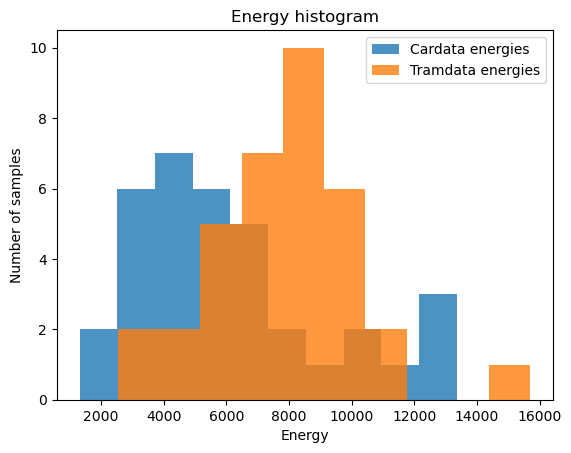

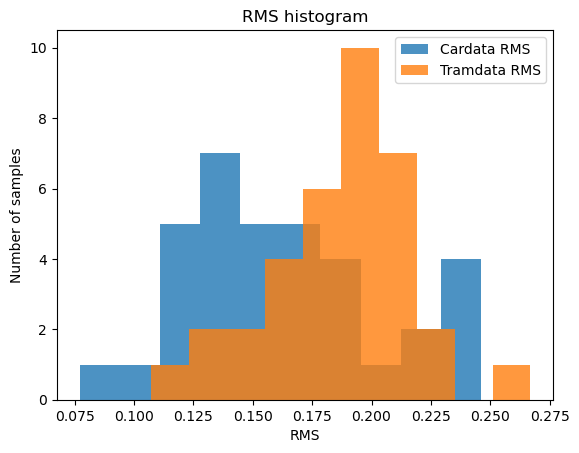

In [7]:
# Plot histograms 
plt.hist(car_energies, label="Cardata energies", alpha=0.8)
plt.hist(tram_energies, label="Tramdata energies", alpha=0.8)
plt.legend()
plt.title("Energy histogram")
plt.xlabel("Energy")
plt.ylabel("Number of samples")
plt.show()

plt.figure()
plt.hist(car_rms, label="Cardata RMS", alpha=0.8)
plt.hist(tram_rms, label="Tramdata RMS", alpha=0.8)
plt.legend()
plt.title("RMS histogram")
plt.xlabel("RMS")
plt.ylabel("Number of samples")
plt.show()

In [8]:
def plot_spectrogram(spectrogram, sr):
    plt.figure(figsize=(10, 4))
    lb.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

Car


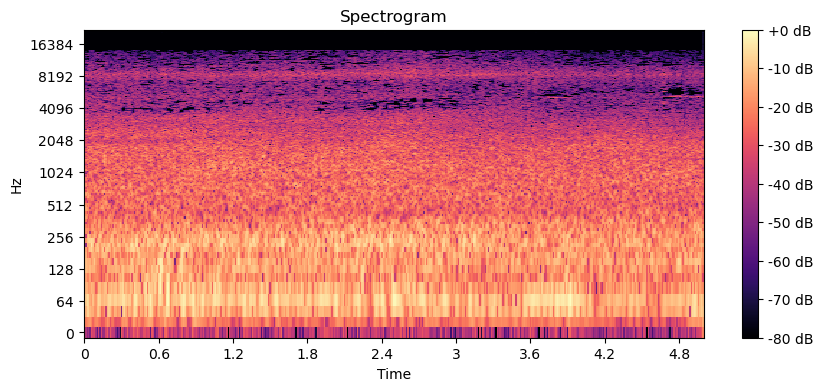

Tram


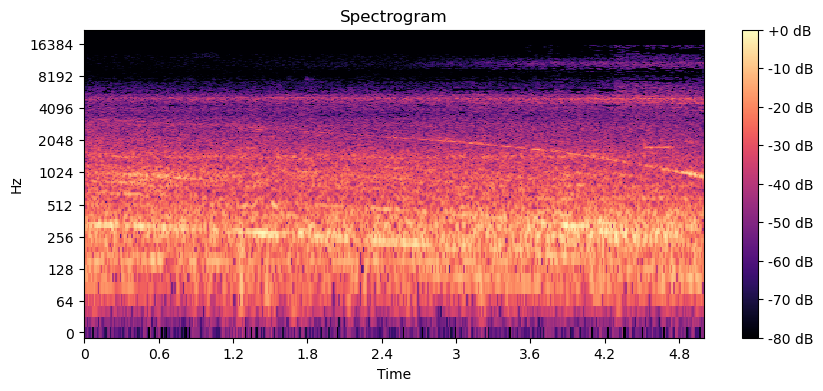

Car


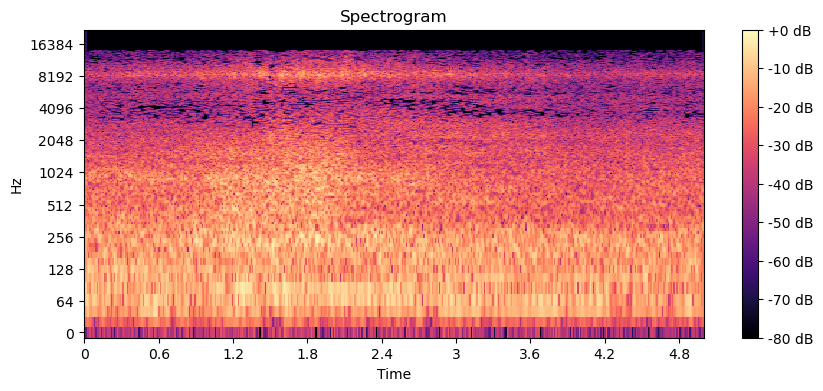

Tram


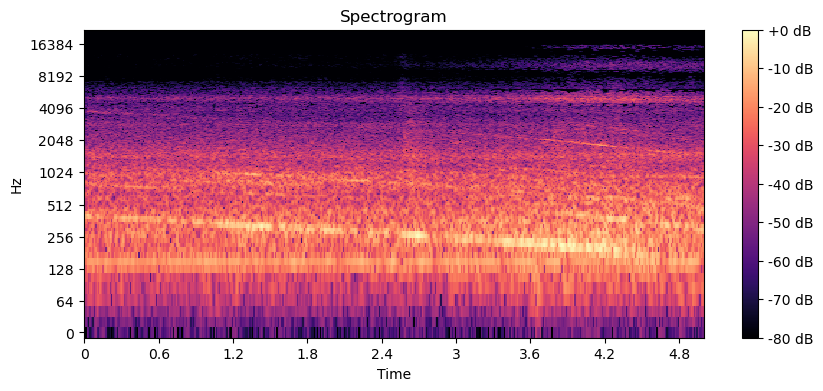

In [9]:
# Calculate spectrograms
car_spectrograms = []
tram_spectrograms = []

for i in range(0, len(cardata)):
    # Car
    spectrogram = lb.amplitude_to_db(np.abs(lb.stft(cardata[i])), ref=np.max)
    car_spectrograms.append(spectrogram.flatten())
    # Tram
    spectrogram2 = lb.amplitude_to_db(np.abs(lb.stft(tramdata[i])), ref=np.max)
    tram_spectrograms.append(spectrogram2.flatten())

    # Plot some of the mel spectrograms
    if i == 5 or i == 15:
        print("Car")
        plot_spectrogram(spectrogram, sr)
        print("Tram")
        plot_spectrogram(spectrogram2, sr)
car_spectrograms = np.array(car_spectrograms)
tram_spectrograms = np.array(tram_spectrograms)

In [10]:
def plot_mel_spectrogram(spectrogram, sr):
    plt.figure(figsize=(10, 4))
    lb.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

Car


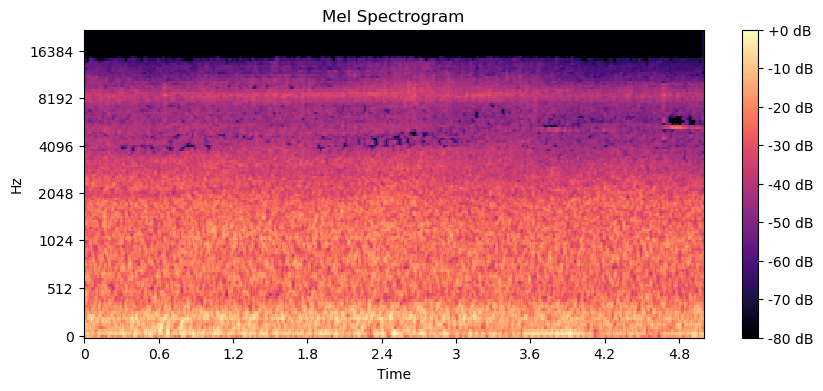

Tram


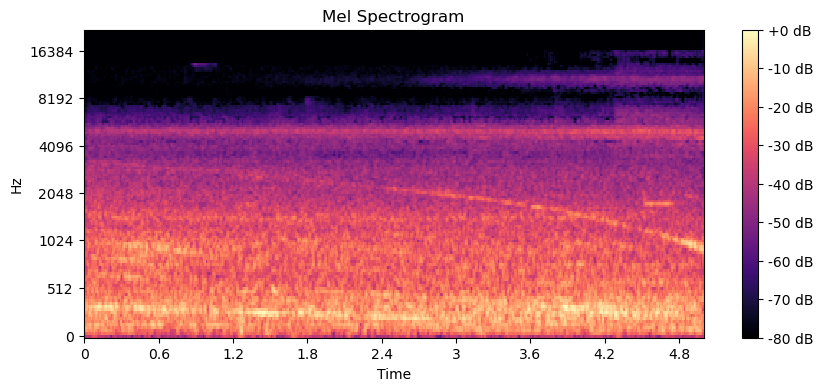

Car


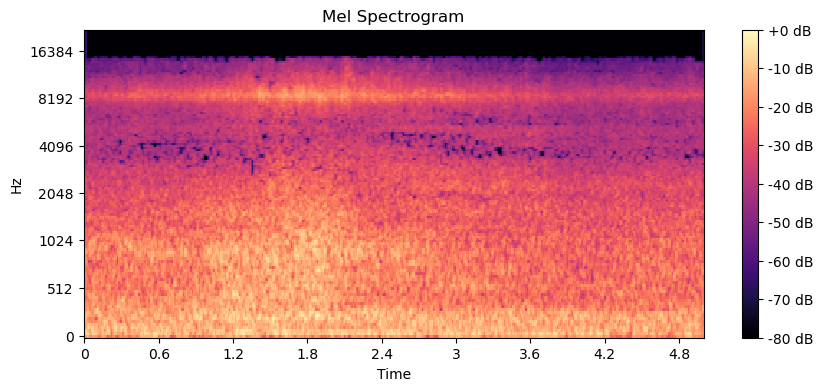

Tram


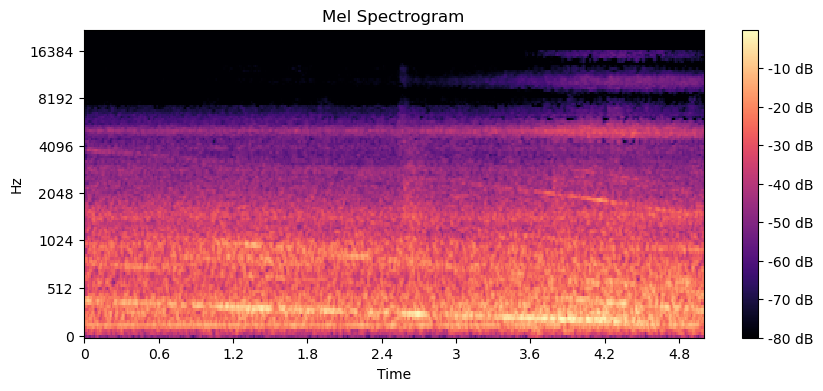

In [11]:
# Calculate mel-spectrograms/log-mel spectrograms
car_mels = []
tram_mels = []

for i in range(0, len(cardata)):
    # Car
    mel_spectrogram = lb.feature.melspectrogram(y=cardata[i], sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spectrogram_db = lb.power_to_db(mel_spectrogram, ref=np.max)
    car_mels.append(mel_spectrogram_db.flatten())

    # Tram
    mel_spectrogram = lb.feature.melspectrogram(y=tramdata[i], sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spectrogram_db2 = lb.power_to_db(mel_spectrogram, ref=np.max)
    tram_mels.append(mel_spectrogram_db2.flatten())

    # Plot some of the mel spectrograms
    if i == 5 or i == 15:
        print("Car")
        plot_mel_spectrogram(mel_spectrogram_db, sr)
        print("Tram")
        plot_mel_spectrogram(mel_spectrogram_db2, sr)
car_mels = np.array(car_mels)
tram_mels = np.array(tram_mels)

In [12]:
def plot_MFCC(mfccs):
    plt.figure(figsize=(10, 4))
    lb.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.ylabel("MFCCs")
    plt.show()

Car


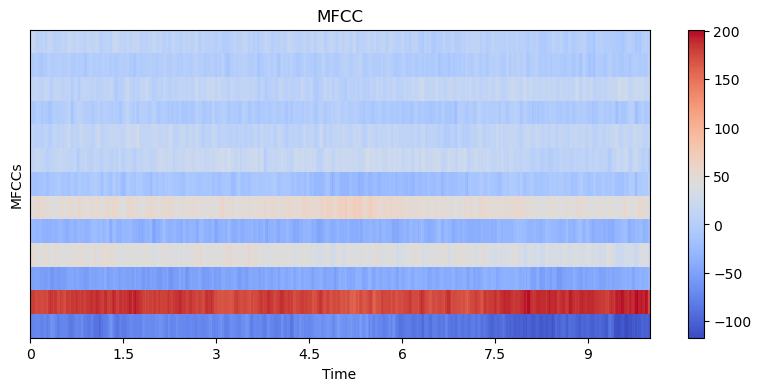

Tram


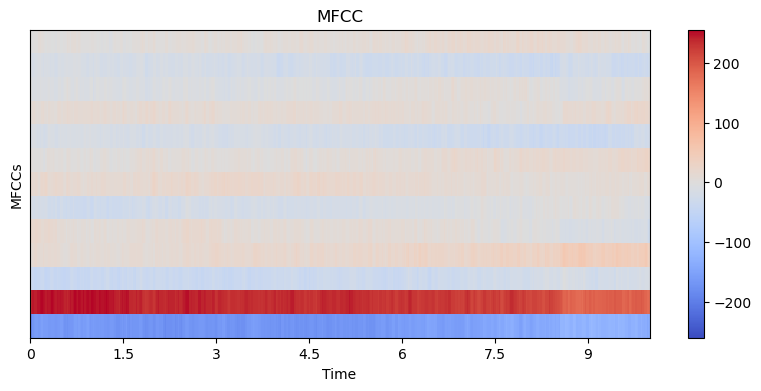

Car


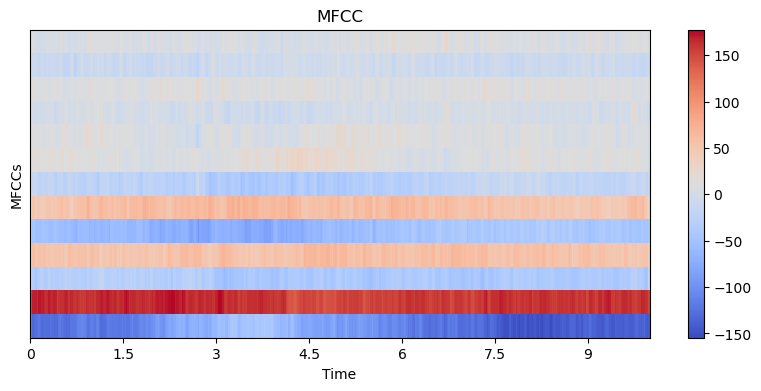

Tram


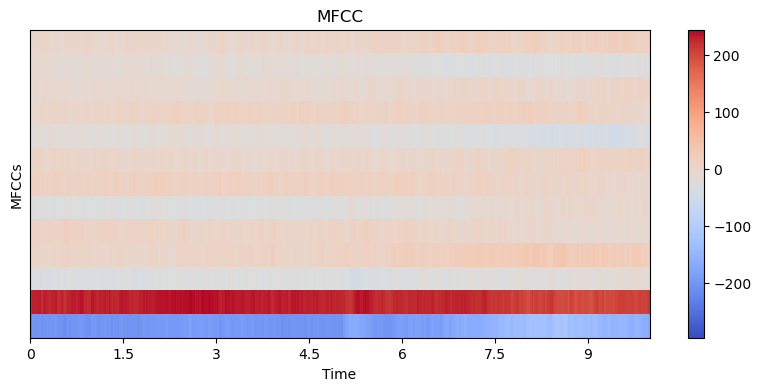

In [13]:
# Calculate MFCCs
car_mfccs = []
tram_mfccs = []

for i in range(0,len(cardata)):
    # Car
    mfccs = lb.feature.mfcc(y=cardata[i], sr=sr, n_mfcc=13)
    car_mfccs.append(mfccs.flatten())
    # Tram
    mfccs2 = lb.feature.mfcc(y=tramdata[i], sr=sr, n_mfcc=13)
    tram_mfccs.append(mfccs2.flatten())
    
    # Display some of the MFCCs
    if i == 5 or i==15:
        print("Car")
        plot_MFCC(mfccs)
        print("Tram") 
        plot_MFCC(mfccs2)
car_mfccs = np.array(car_mfccs)
tram_mfccs = np.array(tram_mfccs)

In [14]:
def plot_CQT(cqt, sr):
    plt.figure(figsize=(10, 4))
    lb.display.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q Spectrogram')
    plt.show()

Car


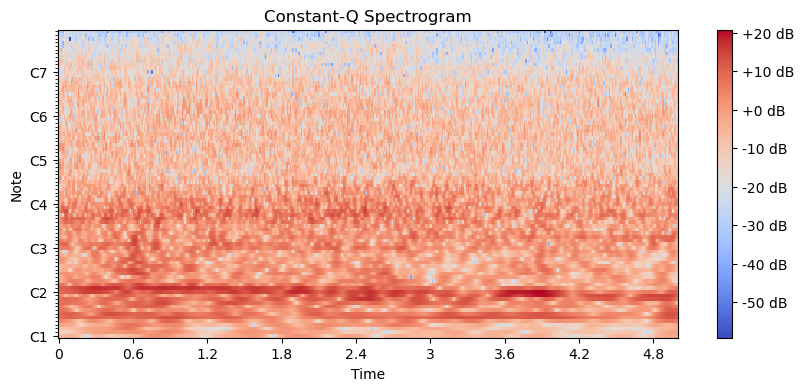

Tram


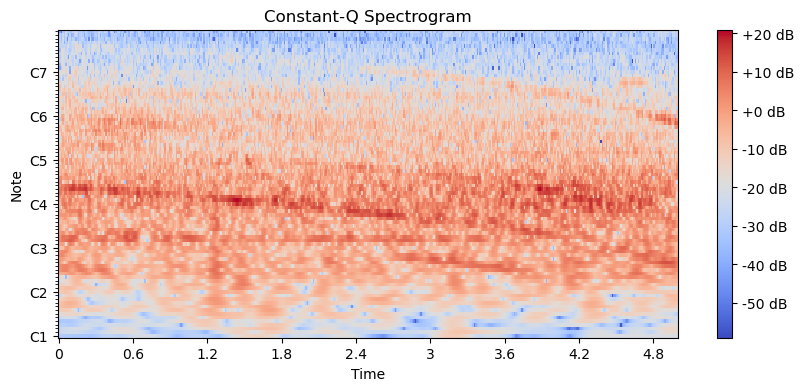

Car


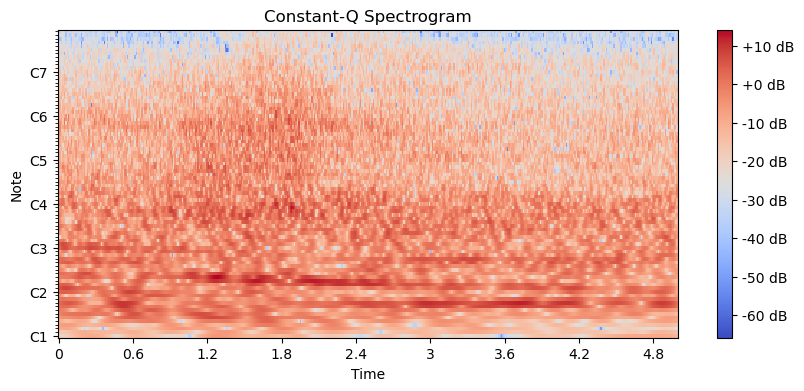

Tram


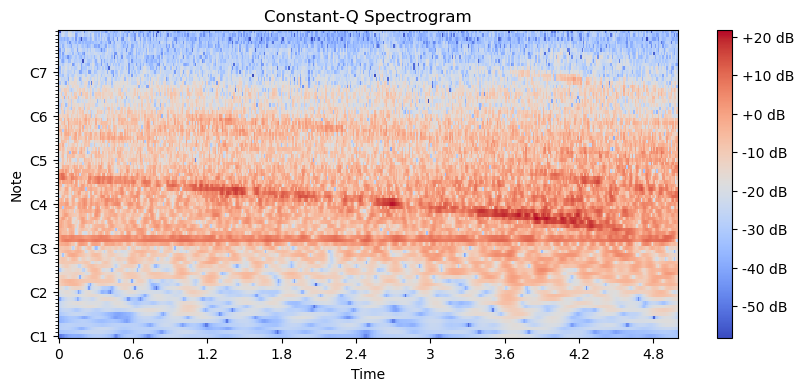

In [15]:
# Calculate CQT-spectrograms
car_cqts = []
tram_cqts = []

for i in range(0,len(cardata)):
    # Car
    cqt_spectrogram = lb.core.cqt(y=cardata[i], sr=sr)
    cqt_spectrogram_db = lb.amplitude_to_db(np.abs(cqt_spectrogram))
    car_cqts.append(cqt_spectrogram_db.flatten())
    # Tram
    cqt_spectrogram = lb.core.cqt(y=tramdata[i], sr=sr)
    cqt_spectrogram_db2 = lb.amplitude_to_db(np.abs(cqt_spectrogram))
    tram_cqts.append(cqt_spectrogram_db2.flatten())
    
    # Display some of the MFCCs
    if i == 5 or i==15:
        print("Car")
        plot_CQT(cqt_spectrogram_db, sr)
        print("Tram")
        plot_CQT(cqt_spectrogram_db2, sr)
car_cqts = np.array(car_cqts)
tram_cqts = np.array(tram_cqts)

Define model

In [61]:
# Divide car and tram datasets to training, validation and test sets
# Label 0 for car, 1 for tram
y_car = np.zeros((35,))
y_tram = np.ones((35,))
y = np.hstack((y_car, y_tram))

#X = np.vstack((car_mfccs, tram_mfccs)) # MFCCs
X = np.vstack((car_mels, tram_mels)) # Mel-spectrograms
#X = np.vstack((car_cqts, tram_cqts)) # CQT-spectrograms

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.28, random_state=42, stratify=y)
print("Training samples", len(X_train))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print("Test samples", len(X_test),", validation samples", len(X_val))

Training samples 50
Test samples 10 , validation samples 10


In [62]:
# Define the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

Train the model

In [63]:
# Fit the model
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [68]:
# Validate model
y_val_pred = knn_model.predict(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

# Precision
val_precision = precision_score(y_val, y_val_pred)
print(f"Validation precision score: {val_precision*100:.2f}%")

# Recall
val_recall = recall_score(y_val, y_val_pred)
print(f"Validation recall score: {val_recall*100:.2f}%")

Validation accuracy: 90.00%
Validation precision score: 83.33%
Validation recall score: 100.00%


In [69]:
# Test model 
y_pred = knn_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Precision
test_precision = precision_score(y_test, y_pred)
print(f"Test precision score: {test_precision*100:.2f}%")

# Recall
test_recall = recall_score(y_test, y_pred)
print(f"Test recall score: {test_recall*100:.2f}%")

Test accuracy: 100.00%
Test precision score: 100.00%
Test recall score: 100.00%
